<a href="https://colab.research.google.com/github/mrinal000/Trial/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo - Time Series Forecasting with TabPFN  🎉

Welcome to the demo of TabPFN for time series forecasting!

In this demo, we will show you how to use TabPFN for time series forecasting. Concretely, we will:

1. **Load time series data** -- you can also bring in time series data from your own problem
2. **Add features** -- we will use default features, but feel free to experiment with your own features!
3. **Perform prediction** -- zero-shot! 😉
4. **Visualize the forecasting results**


## Setup

In [1]:
!pip install tabpfn-time-series

# for downloading datasets
!pip install datasets

## Load Time Series Data

In this demo, we will use the time series dataset from [Chronos Dataset](https://huggingface.co/datasets/autogluon/chronos_datasets) on HuggingFace. Also, we'll keep it short and work with just 2 time series from the dataset.

Feel free to explore other datasets by using the dataset names from Chronos Dataset on HuggingFace or even use time series data of your own problem.

In [3]:
dataset_metadata = {
    "monash_tourism_monthly": {"prediction_length": 24},
    "m4_hourly": {"prediction_length": 48},
}

dataset_choice = "monash_tourism_monthly"
num_time_series_subset = 2

In [4]:
from datasets import load_dataset
from autogluon.timeseries import TimeSeriesDataFrame

from tabpfn_time_series.data_preparation import to_gluonts_univariate, generate_test_X

prediction_length = dataset_metadata[dataset_choice]['prediction_length']
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)

tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset['train']))
tsdf = tsdf[tsdf.index.get_level_values('item_id').isin(tsdf.item_ids[:num_time_series_subset])]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/44.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/335k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/366 [00:00<?, ? examples/s]

Let's take a look at the time series data.

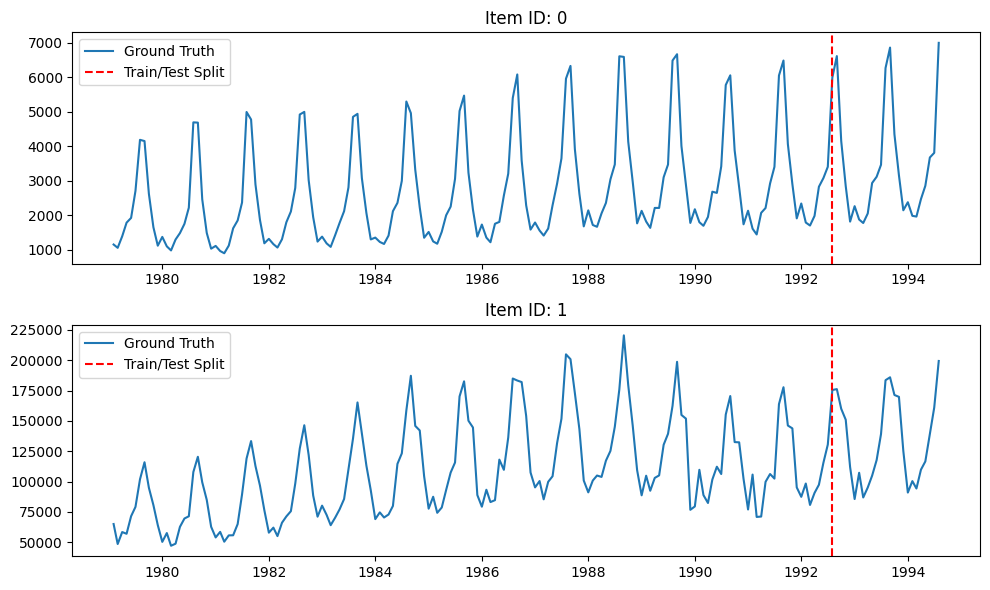

In [5]:
from tabpfn_time_series.plot import plot_actual_ts

plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

## Adding Features

In our paper, we propose adding `running_index` and `calendar_features` to the table.

**Feel free to experiment with your own features!**

To do that, simply define your own feature functions and pass them to the `FeatureTransformer`.

In [6]:
from tabpfn_time_series import FeatureTransformer, DefaultFeatures

selected_features = [
    DefaultFeatures.add_running_index,
    DefaultFeatures.add_calendar_features,
]

train_tsdf, test_tsdf = FeatureTransformer.add_features(
    train_tsdf, test_tsdf, selected_features
)


Let's take a look at the tables (train and test) before we proceed to do predictions.

✅ Realize that we have added some features into the tables.

In [7]:
train_tsdf.head()

target  running_index  year  hour_of_day_sin  \
item_id timestamp                                                     
0       1979-01-31  1149.8700              0  1979              0.0   
        1979-02-28  1053.8002              1  1979              0.0   
        1979-03-31  1388.8798              2  1979              0.0   
        1979-04-30  1783.3702              3  1979              0.0   
        1979-05-31  1921.0252              4  1979              0.0   

                    hour_of_day_cos  day_of_week_sin  day_of_week_cos  \
item_id timestamp                                                       
0       1979-01-31              1.0     8.660254e-01             -0.5   
        1979-02-28              1.0     8.660254e-01             -0.5   
        1979-03-31              1.0    -8.660254e-01              0.5   
        1979-04-30              1.0     0.000000e+00              1.0   
        1979-05-31              1.0     1.224647e-16             -1.0   

                    day_of_month_sin  day_of_month_cos  day_of_year_sin  \
item_id timestamp                                                         
0       1979-01-31          0.106293          0.994335         0.495009   
        1979-02-28         -0.507666          0.861554         0.842101   
        1979-03-31          0.106293          0.994335         0.999404   
        1979-04-30         -0.106293          0.994335         0.885456   
        1979-05-31          0.106293          0.994335         0.524704   

                    day_of_year_cos  week_of_year_sin  week_of_year_cos  \
item_id timestamp                                                         
0       1979-01-31         0.868888          0.473094          0.881012   
        1979-02-28         0.539320          0.833602          0.552365   
        1979-03-31         0.034516          0.995734          0.092268   
        1979-04-30        -0.464723          0.866025         -0.500000   
        1979-05-31        -0.851284          0.526432         -0.850217   

                    month_of_year_sin  month_of_year_cos  
item_id timestamp                                         
0       1979-01-31           0.000000           1.000000  
        1979-02-28           0.540641           0.841254  
        1979-03-31           0.909632           0.415415  
        1979-04-30           0.989821          -0.142315  
        1979-05-31           0.755750          -0.654861

In [8]:
test_tsdf.head()

target  running_index  year  hour_of_day_sin  \
item_id timestamp                                                  
0       1992-08-31     NaN            163  1992              0.0   
        1992-09-30     NaN            164  1992              0.0   
        1992-10-31     NaN            165  1992              0.0   
        1992-11-30     NaN            166  1992              0.0   
        1992-12-31     NaN            167  1992              0.0   

                    hour_of_day_cos  day_of_week_sin  day_of_week_cos  \
item_id timestamp                                                       
0       1992-08-31              1.0     0.000000e+00              1.0   
        1992-09-30              1.0     8.660254e-01             -0.5   
        1992-10-31              1.0    -8.660254e-01              0.5   
        1992-11-30              1.0     0.000000e+00              1.0   
        1992-12-31              1.0     1.224647e-16             -1.0   

                    day_of_month_sin  day_of_month_cos  day_of_year_sin  \
item_id timestamp                                                         
0       1992-08-31          0.106293          0.994335        -0.868888   
        1992-09-30         -0.106293          0.994335        -1.000000   
        1992-10-31          0.106293          0.994335        -0.860214   
        1992-11-30         -0.106293          0.994335        -0.495009   
        1992-12-31          0.106293          0.994335         0.017261   

                    day_of_year_cos  week_of_year_sin  week_of_year_cos  \
item_id timestamp                                                         
0       1992-08-31    -4.950088e-01         -0.920906         -0.389786   
        1992-09-30    -1.836970e-16         -0.995734          0.092268   
        1992-10-31     5.099326e-01         -0.833602          0.552365   
        1992-11-30     8.688880e-01         -0.361242          0.932472   
        1992-12-31     9.998510e-01          0.122888          0.992421   

                    month_of_year_sin  month_of_year_cos  
item_id timestamp                                         
0       1992-08-31      -7.557496e-01          -0.654861  
        1992-09-30      -9.898214e-01          -0.142315  
        1992-10-31      -9.096320e-01           0.415415  
        1992-11-30      -5.406408e-01           0.841254  
        1992-12-31      -1.133108e-15           1.000000

## Prediction

Now, let's perform prediction.

We provide two options, `TabPFNMode.LOCAL` and `TabPFNMode.CLIENT`, as the backend for TabPFN.

- `TabPFNMode.LOCAL` uses your local machine to run TabPFN.
- `TabPFNMode.CLIENT` uses TabPFN's inference service provided by [tabpfn-client](https://github.com/automl/tabpfn-client)

For this demo, we'll use `TabPFNMode.CLIENT` to perform prediction. If you have not use the client before, you'll be prompted to create an account.

Note: if your machine doesn't have a GPU, using `TabPFNMode.CLIENT` is recommended -- must faster 😉.


In [10]:
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.CLIENT,
)

pred = predictor.predict(train_tsdf, test_tsdf)

  Welcome to TabPFN!

  TabPFN is still under active development, and we are working hard to make it better.
  Please bear with us if you encounter any issues.


Opening browser for login. Please complete the login/registration process in your browser and return here.


Could not open browser automatically. Falling back to command-line login...

  Please choose one of the following options:
  (1) Create a TabPFN account
  (2) Login to your TabPFN account

  Please enter your choice: Create
  Invalid choice, please enter '1' or '2': 1

  Please refer to our terms and conditions at: https://www.priorlabs.ai/terms By using TabPFN, you agree to the following terms and conditions:
  Do you agree to the above terms and conditions? (y/n): y
  Please enter your email: drofartscience@gmail.com

  Password requirements (minimum):
  . Length(8)
  . Uppercase(1)
  . Numbers(1)
  . Special(1)

  Please enter your password: ··········
  Password requirements not satisfied.

  Please enter your passw

Predicting time series: 100%|██████████| 2/2 [00:00<00:00, 36.53it/s]


## Visualize the Results

Let's visualize the forecasting results.

Also, note that we provide both **point prediction** and **quantile prediction**, how amazing! 😄

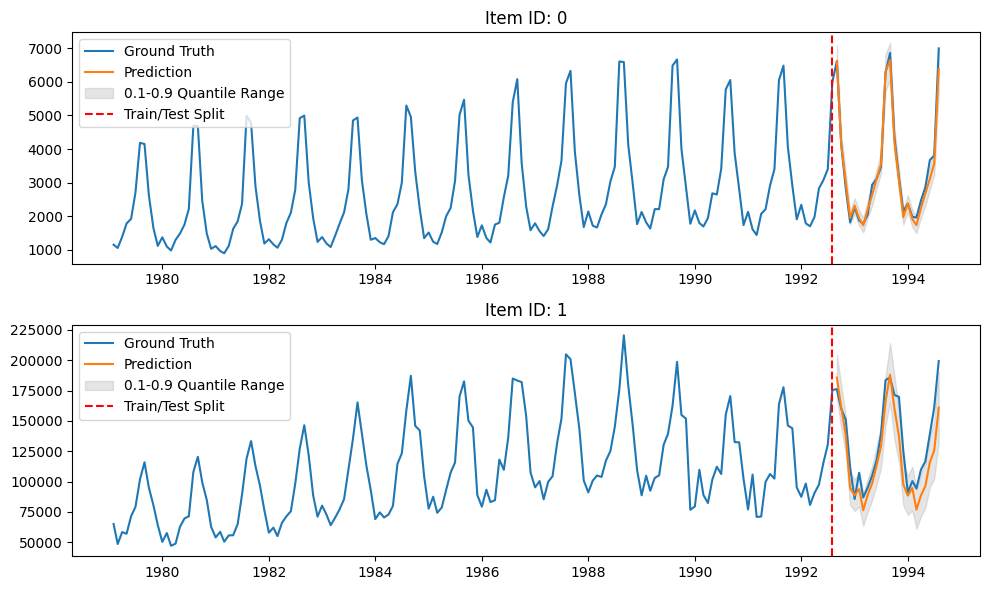

In [11]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts

plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf_ground_truth,
    pred=pred,
)

In [12]:
pred.head()

target          0.1          0.2          0.3  \
item_id timestamp                                                        
0       1992-08-31  6606.800781  6102.414062  6293.967285  6416.009277   
        1992-09-30  4140.993652  3830.508789  3941.410889  4018.960938   
        1992-10-31  3037.699219  2789.153076  2876.940430  2939.081299   
        1992-11-30  1951.452148  1760.046509  1826.744629  1873.631104   
        1992-12-31  2316.676514  2074.265381  2160.809082  2220.857666   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
0       1992-08-31  6516.358887  6606.800781  6692.228027  6785.649414   
        1992-09-30  4082.964844  4140.993652  4200.961914  4262.429199   
        1992-10-31  2989.551758  3037.699219  3087.941406  3141.155762   
        1992-11-30  1914.281494  1951.452148  1990.329102  2032.867065   
        1992-12-31  2271.414795  2316.676514  2362.454834  2408.845947   

                            0.8          0.9  
item_id timestamp                             
0       1992-08-31  6902.547852  7085.281250  
        1992-09-30  4341.889648  4462.779297  
        1992-10-31  3206.742676  3305.148438  
        1992-11-30  2083.922119  2160.845703  
        1992-12-31  2463.008545  2536.531738

# Feedback

Let us know what you think!

Write us at Discord: https://discord.gg/qK7AaXPN or just simply create an issue on [GitHub](https://github.com/liam-sbhoo/tabpfn-time-series/tree/main).

Thank you for trying out our method! 🎉
